## Import

In [1]:
import os
import cv2
from PIL import Image
import pandas as pd
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms

from tqdm import tqdm

#데이터 증강기법 활용을 위한 라이브러리 임포트
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import (
    Compose, HorizontalFlip, Rotate, RandomBrightnessContrast,
    Resize, Normalize)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

/usr/local/lib/python3.8/dist-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.0' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


cuda


In [2]:
DATA_DIR = './open'

x_train_dir = os.path.join(DATA_DIR, 'train_source_image')
y_train_dir = os.path.join(DATA_DIR, 'train_source_gt')

x_valid_dir = os.path.join(DATA_DIR, 'val_source_image')
y_valid_dir = os.path.join(DATA_DIR, 'val_source_gt')

x_test_dir = os.path.join(DATA_DIR, 'test_image')
#y_test_dir = os.path.join(DATA_DIR, 'testannot')


In [3]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

## Utils

In [4]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

## Custom Dataset

In [9]:
class Dataset(BaseDataset):
    CLASSES = ['Road', 'Sidewalk', 'Construction', 'Fence', 'Pole', 
               'Traffic Light', 'Traffic Sign', 'Nature', 'Sky', 
               'Person', 'Rider', 'Car']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir=None, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
            infer=False,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]

        if masks_dir:
            self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        else:
            self.masks_fps = None
            
        self.infer = infer
        
        # If classes are not provided, default to all classes
        if not classes:
            classes = self.CLASSES

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.title()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
        # Check if masks_fps is not None
        mask = None
        if self.masks_fps:
            mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_GRAYSCALE)
            # adjust mask values for 'unlabelled' class
            mask[mask == 255] = 12

        # apply augmentations
        if self.augmentation:
            if mask is not None:
                sample = self.augmentation(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                image = self.augmentation(image=image)['image']

        # apply preprocessing
        if self.preprocessing:
            if mask is not None:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
            else:
                image = self.preprocessing(image=image)['image']

        return (image, mask) if mask is not None else image


        if self.infer:
            if self.augmentation:
                image = self.augmentation(image=image)['image']
            
    def __len__(self):
        return len(self.ids)


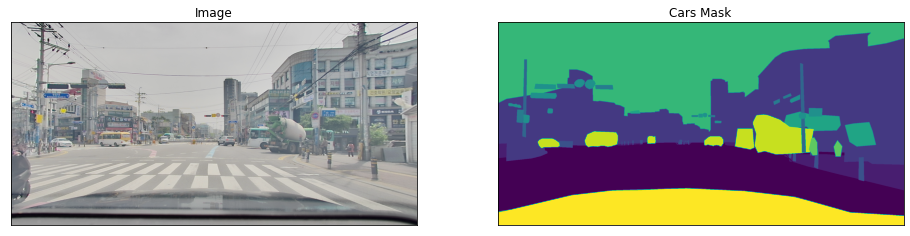

In [10]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)

image, mask = dataset[4] # get some sample
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
)

In [11]:
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.OpticalDistortion(p=1, distort_limit=5, shift_limit=5),  # OpticalDistortion 적용
        
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        #albu.PadIfNeeded(min_height=960, min_width=540, always_apply=True, border_mode=0),
        albu.CenterCrop(height=512, width=512, always_apply=True),
        albu.GaussNoise(p=0.2),
        albu.Perspective(p=0.5),
        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),
        albu.OneOf(
            [
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

def get_validation_augmentation():
    """Add paddings to make image shape 224x224"""
    test_transform = [
        #albu.PadIfNeeded(960, 540),
        albu.CenterCrop(height=512, width=512, always_apply=True)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    if len(x.shape) == 3:
        return x.transpose(2, 0, 1).astype('float32')
    elif len(x.shape) == 2:
        return x.astype('float32')
    else:
        raise ValueError("Invalid array shape!")


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(1024, 2048, 3)
(1024, 2048)


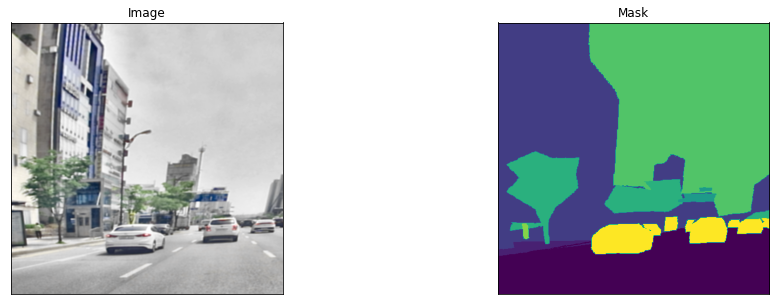

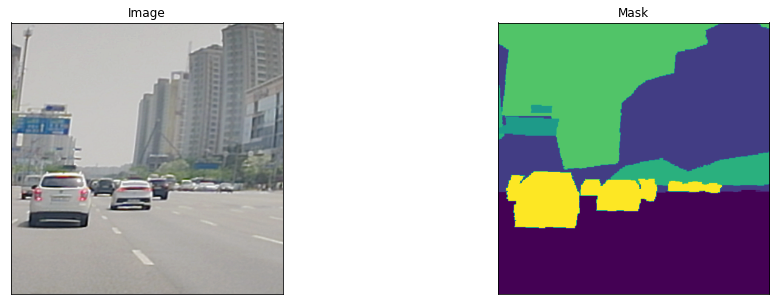

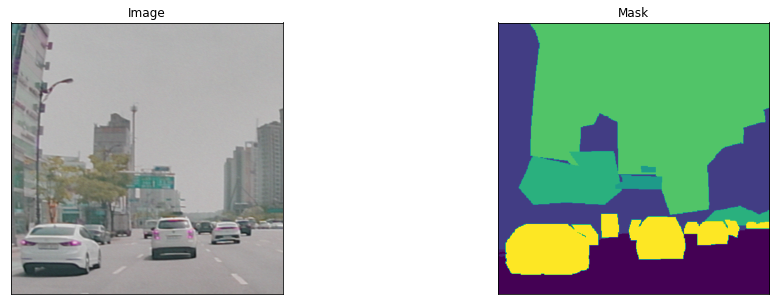

In [13]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation()
)
print(image.shape)
print(mask.shape)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[3]
    visualize(image=image, mask=mask)

In [14]:
import sys

# 원하는 디렉토리 경로 추가
sys.path.append('/home/work/CPS_Project/Samsung AI-Challenge')

# 모듈 임포트
# from utils import your_util_function  # 필요한 함수 또는 클래스를 임포트

# 이제 해당 모듈의 함수나 클래스를 사용할 수 있습니다.

In [15]:
import torch
import numpy as np
import segmentation_models_pytorch as smp
from segmentation_models_pytorch import utils

In [16]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
NUM_CLASSES = 13
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=NUM_CLASSES, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [ ]:
print(model)

In [18]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [19]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

for images, masks in valid_loader:
    print(images.shape, masks.shape)
    break

torch.Size([16, 3, 512, 512]) torch.Size([16, 512, 512])
torch.Size([1, 3, 512, 512]) torch.Size([1, 512, 512])


In [20]:
mask_path = "/home/work/CPS_Project/Samsung AI-Challenge/open/train_source_gt/TRAIN_SOURCE_0024.png"
mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

unique_values = np.unique(mask)
print(unique_values)

[  0   1   2   3   4   6   7   8  11 255]


In [21]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

device = DEVICE
criterion = torch.nn.CrossEntropyLoss()

In [23]:
# IoU 계산 함수
def iou_score(output, target):
    smooth = 1e-5

    n_classes = output.shape[1]
    ious = []

    for cls in range(n_classes):
        cls_output = output[:, cls, :, :]
        cls_target = (target == cls).float()

        intersection = (cls_output * cls_target).sum()
        union = cls_output.sum() + cls_target.sum() - intersection

        ious.append((intersection + smooth) / (union + smooth))

    return sum(ious) / len(ious)

# 초기 설정
best_miou = 0
save_path = './Samsung_best_model4.pth'
model = model.to(device)

# 학습 루프
for epoch in range(100):
    model.train()
    epoch_loss = 0
    total_iou = 0

    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        total_iou += iou_score(outputs.detach(), masks.squeeze(1).detach())

    avg_miou = total_iou / len(train_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}, mIoU: {avg_miou}')
    
    # Validation and Save best model
    model.eval()
    total_val_iou = 0
    with torch.no_grad():
        for images, masks in tqdm(valid_loader):
            images = images.float().to(device)
            masks = masks.long().to(device)
            outputs = model(images)
            total_val_iou += iou_score(outputs, masks.squeeze(1))
    avg_val_miou = total_val_iou / len(valid_loader)
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(valid_loader)}, mIoU: {avg_val_miou}')
    print(f'Validation mIoU: {avg_val_miou}')

    if avg_val_miou > best_miou:
        best_miou = avg_val_miou
        torch.save(model.state_dict(), save_path)
        print(f'Model saved at {save_path} with mIoU: {best_miou}')

    # 50 epochs마다 learning rate 조정
    if (epoch+1) % 30 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.1
        print(f'Learning rate reduced to {param_group["lr"]}')


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 1, Loss: 1.9174164386763088, mIoU: 0.24927200376987457


100%|██████████| 466/466 [00:19<00:00, 23.85it/s]


Epoch 1, Loss: 0.5678186020114391, mIoU: 0.28736478090286255
Validation mIoU: 0.28736478090286255
Model saved at ./Samsung_best_model4.pth with mIoU: 0.28736478090286255


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 2, Loss: 1.8120634322581084, mIoU: 0.31098639965057373


100%|██████████| 466/466 [00:19<00:00, 23.61it/s]


Epoch 2, Loss: 0.5366196430292253, mIoU: 0.2937442362308502
Validation mIoU: 0.2937442362308502
Model saved at ./Samsung_best_model4.pth with mIoU: 0.2937442362308502


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 3, Loss: 1.7992302110229714, mIoU: 0.3190821409225464


100%|██████████| 466/466 [00:19<00:00, 23.50it/s]


Epoch 3, Loss: 0.5328192470411375, mIoU: 0.2974343001842499
Validation mIoU: 0.2974343001842499
Model saved at ./Samsung_best_model4.pth with mIoU: 0.2974343001842499


100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


Epoch 4, Loss: 1.7997223173362622, mIoU: 0.32027268409729004


100%|██████████| 466/466 [00:19<00:00, 23.61it/s]


Epoch 4, Loss: 0.532964978095288, mIoU: 0.29567405581474304
Validation mIoU: 0.29567405581474304


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 5, Loss: 1.7942927341530288, mIoU: 0.3325539529323578


100%|██████████| 466/466 [00:19<00:00, 23.49it/s]


Epoch 5, Loss: 0.5313570757792231, mIoU: 0.2980322241783142
Validation mIoU: 0.2980322241783142
Model saved at ./Samsung_best_model4.pth with mIoU: 0.2980322241783142


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 6, Loss: 1.772616690483646, mIoU: 0.4092247188091278


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 6, Loss: 0.5249379898857149, mIoU: 0.3165065050125122
Validation mIoU: 0.3165065050125122
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3165065050125122


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 7, Loss: 1.7665847030238828, mIoU: 0.4395287036895752


100%|██████████| 466/466 [00:19<00:00, 23.60it/s]


Epoch 7, Loss: 0.5231516931701627, mIoU: 0.32743096351623535
Validation mIoU: 0.32743096351623535
Model saved at ./Samsung_best_model4.pth with mIoU: 0.32743096351623535


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 8, Loss: 1.761986129525779, mIoU: 0.4762175381183624


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 8, Loss: 0.5217898838509818, mIoU: 0.3350568413734436
Validation mIoU: 0.3350568413734436
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3350568413734436


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 9, Loss: 1.7589508813360464, mIoU: 0.4877842962741852


100%|██████████| 466/466 [00:19<00:00, 23.66it/s]


Epoch 9, Loss: 0.5208910335287004, mIoU: 0.3359483778476715
Validation mIoU: 0.3359483778476715
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3359483778476715


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 10, Loss: 1.7572870124941287, mIoU: 0.491679310798645


100%|██████████| 466/466 [00:19<00:00, 23.59it/s]


Epoch 10, Loss: 0.5203982998373171, mIoU: 0.33704033493995667
Validation mIoU: 0.33704033493995667
Model saved at ./Samsung_best_model4.pth with mIoU: 0.33704033493995667


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 11, Loss: 1.7563603701798811, mIoU: 0.4972487688064575


100%|██████████| 466/466 [00:19<00:00, 23.62it/s]


Epoch 11, Loss: 0.5201238864481194, mIoU: 0.336587131023407
Validation mIoU: 0.336587131023407


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 12, Loss: 1.757490140804346, mIoU: 0.49483025074005127


100%|██████████| 466/466 [00:19<00:00, 23.56it/s]


Epoch 12, Loss: 0.5204584537145918, mIoU: 0.33470186591148376
Validation mIoU: 0.33470186591148376


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 13, Loss: 1.7543878598489624, mIoU: 0.5007857084274292


100%|██████████| 466/466 [00:19<00:00, 23.69it/s]


Epoch 13, Loss: 0.519539752487461, mIoU: 0.3362441062927246
Validation mIoU: 0.3362441062927246


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 14, Loss: 1.7534612322199172, mIoU: 0.5012809038162231


100%|██████████| 466/466 [00:19<00:00, 23.74it/s]


Epoch 14, Loss: 0.5192653434471, mIoU: 0.3399471044540405
Validation mIoU: 0.3399471044540405
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3399471044540405


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 15, Loss: 1.7519858038943747, mIoU: 0.5059105157852173


100%|██████████| 466/466 [00:19<00:00, 23.68it/s]


Epoch 15, Loss: 0.5188284140288062, mIoU: 0.33952775597572327
Validation mIoU: 0.33952775597572327


100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


Epoch 16, Loss: 1.7514961439630259, mIoU: 0.5061579346656799


100%|██████████| 466/466 [00:19<00:00, 23.68it/s]


Epoch 16, Loss: 0.5186834074396944, mIoU: 0.3429861068725586
Validation mIoU: 0.3429861068725586
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3429861068725586


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 17, Loss: 1.7507389611092166, mIoU: 0.5054398775100708


100%|██████████| 466/466 [00:19<00:00, 23.49it/s]


Epoch 17, Loss: 0.5184591773241887, mIoU: 0.34020888805389404
Validation mIoU: 0.34020888805389404


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 18, Loss: 1.7501585466274316, mIoU: 0.508734405040741


100%|██████████| 466/466 [00:19<00:00, 23.59it/s]


Epoch 18, Loss: 0.5182872949240034, mIoU: 0.34250855445861816
Validation mIoU: 0.34250855445861816


100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


Epoch 19, Loss: 1.7500685548436814, mIoU: 0.5078880786895752


100%|██████████| 466/466 [00:19<00:00, 23.77it/s]


Epoch 19, Loss: 0.5182606449966267, mIoU: 0.341815710067749
Validation mIoU: 0.341815710067749


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 20, Loss: 1.7511755055275515, mIoU: 0.5092191100120544


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 20, Loss: 0.518588454426614, mIoU: 0.3388833701610565
Validation mIoU: 0.3388833701610565


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 21, Loss: 1.749015061751656, mIoU: 0.5119374394416809


100%|██████████| 466/466 [00:19<00:00, 23.64it/s]


Epoch 21, Loss: 0.5179486663556406, mIoU: 0.3404490649700165
Validation mIoU: 0.3404490649700165


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 22, Loss: 1.7540583610534668, mIoU: 0.5035300850868225


100%|██████████| 466/466 [00:19<00:00, 23.70it/s]


Epoch 22, Loss: 0.5194421755909409, mIoU: 0.342109352350235
Validation mIoU: 0.342109352350235


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 23, Loss: 1.7485354568647302, mIoU: 0.513465404510498


100%|██████████| 466/466 [00:19<00:00, 23.69it/s]


Epoch 23, Loss: 0.5178066374406283, mIoU: 0.3437419831752777
Validation mIoU: 0.3437419831752777
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3437419831752777


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 24, Loss: 1.7479132638461348, mIoU: 0.5153912901878357


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 24, Loss: 0.5176223828557224, mIoU: 0.3421144485473633
Validation mIoU: 0.3421144485473633


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 25, Loss: 1.7470901573913684, mIoU: 0.5240081548690796


100%|██████████| 466/466 [00:19<00:00, 23.68it/s]


Epoch 25, Loss: 0.5173786303004482, mIoU: 0.34099844098091125
Validation mIoU: 0.34099844098091125


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 26, Loss: 1.747701164604961, mIoU: 0.5245898962020874


100%|██████████| 466/466 [00:19<00:00, 23.75it/s]


Epoch 26, Loss: 0.5175595723508254, mIoU: 0.3407469391822815
Validation mIoU: 0.3407469391822815


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 27, Loss: 1.7459874014923538, mIoU: 0.5293225646018982


100%|██████████| 466/466 [00:19<00:00, 23.76it/s]


Epoch 27, Loss: 0.5170520631028859, mIoU: 0.33941715955734253
Validation mIoU: 0.33941715955734253


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 28, Loss: 1.745319436425748, mIoU: 0.5308776497840881


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 28, Loss: 0.516854253705479, mIoU: 0.3416864275932312
Validation mIoU: 0.3416864275932312


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 29, Loss: 1.7454567534336145, mIoU: 0.5406175255775452


100%|██████████| 466/466 [00:19<00:00, 23.60it/s]


Epoch 29, Loss: 0.5168949183987958, mIoU: 0.3411397933959961
Validation mIoU: 0.3411397933959961


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 30, Loss: 1.744298689607261, mIoU: 0.5373806953430176


100%|██████████| 466/466 [00:19<00:00, 23.74it/s]


Epoch 30, Loss: 0.5165519724588026, mIoU: 0.3417534828186035
Validation mIoU: 0.3417534828186035
Learning rate reduced to 1e-05


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 31, Loss: 1.7432320092035376, mIoU: 0.5428051948547363


100%|██████████| 466/466 [00:19<00:00, 23.64it/s]


Epoch 31, Loss: 0.516236088562421, mIoU: 0.3434019982814789
Validation mIoU: 0.3434019982814789


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 32, Loss: 1.7427411900050398, mIoU: 0.5456759333610535


100%|██████████| 466/466 [00:19<00:00, 23.68it/s]


Epoch 32, Loss: 0.5160907386710204, mIoU: 0.3430614769458771
Validation mIoU: 0.3430614769458771


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 33, Loss: 1.7417382831158845, mIoU: 0.546528697013855


100%|██████████| 466/466 [00:19<00:00, 23.68it/s]


Epoch 33, Loss: 0.5157937404935452, mIoU: 0.3433729112148285
Validation mIoU: 0.3433729112148285


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 34, Loss: 1.7423714252485745, mIoU: 0.5451732873916626


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 34, Loss: 0.5159812375199642, mIoU: 0.3429817259311676
Validation mIoU: 0.3429817259311676


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 35, Loss: 1.742556393146515, mIoU: 0.5478703379631042


100%|██████████| 466/466 [00:19<00:00, 23.59it/s]


Epoch 35, Loss: 0.516036013421071, mIoU: 0.34368839859962463
Validation mIoU: 0.34368839859962463


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 36, Loss: 1.7408002468122952, mIoU: 0.550531804561615


100%|██████████| 466/466 [00:19<00:00, 23.71it/s]


Epoch 36, Loss: 0.5155159529186625, mIoU: 0.34322401881217957
Validation mIoU: 0.34322401881217957


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 37, Loss: 1.741978672967441, mIoU: 0.5485813021659851


100%|██████████| 466/466 [00:19<00:00, 23.69it/s]


Epoch 37, Loss: 0.5158649289045211, mIoU: 0.3443664610385895
Validation mIoU: 0.3443664610385895
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3443664610385895


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 38, Loss: 1.7418903449307317, mIoU: 0.5483704209327698


100%|██████████| 466/466 [00:19<00:00, 23.59it/s]


Epoch 38, Loss: 0.515838771674766, mIoU: 0.34429770708084106
Validation mIoU: 0.34429770708084106


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 39, Loss: 1.741382122039795, mIoU: 0.5484892725944519


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 39, Loss: 0.5156882679001967, mIoU: 0.342947781085968
Validation mIoU: 0.342947781085968


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 40, Loss: 1.7411730349927708, mIoU: 0.5439844131469727


100%|██████████| 466/466 [00:19<00:00, 23.71it/s]


Epoch 40, Loss: 0.5156263494184601, mIoU: 0.34374865889549255
Validation mIoU: 0.34374865889549255


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 41, Loss: 1.7410451191059058, mIoU: 0.5499979853630066


100%|██████████| 466/466 [00:19<00:00, 23.46it/s]


Epoch 41, Loss: 0.5155884687481008, mIoU: 0.34382206201553345
Validation mIoU: 0.34382206201553345


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 42, Loss: 1.7429411247156668, mIoU: 0.5485106110572815


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 42, Loss: 0.5161499468042103, mIoU: 0.34363242983818054
Validation mIoU: 0.34363242983818054


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 43, Loss: 1.7429650460464368, mIoU: 0.5490477681159973


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 43, Loss: 0.5161570308034512, mIoU: 0.343246191740036
Validation mIoU: 0.343246191740036


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 44, Loss: 1.7413275120914846, mIoU: 0.5501094460487366


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 44, Loss: 0.5156720958554182, mIoU: 0.34343990683555603
Validation mIoU: 0.34343990683555603


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 45, Loss: 1.74081329850183, mIoU: 0.5534186363220215


100%|██████████| 466/466 [00:19<00:00, 23.80it/s]


Epoch 45, Loss: 0.5155198180112716, mIoU: 0.34380441904067993
Validation mIoU: 0.34380441904067993


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 46, Loss: 1.7411715854769167, mIoU: 0.548682451248169


100%|██████████| 466/466 [00:19<00:00, 23.75it/s]


Epoch 46, Loss: 0.515625920162692, mIoU: 0.3438093364238739
Validation mIoU: 0.3438093364238739


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 47, Loss: 1.740467375603275, mIoU: 0.5521045327186584


100%|██████████| 466/466 [00:19<00:00, 23.82it/s]


Epoch 47, Loss: 0.515417377324575, mIoU: 0.34403952956199646
Validation mIoU: 0.34403952956199646


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 48, Loss: 1.7408845761547918, mIoU: 0.5486183762550354


100%|██████████| 466/466 [00:19<00:00, 23.71it/s]


Epoch 48, Loss: 0.5155409259857537, mIoU: 0.3426333963871002
Validation mIoU: 0.3426333963871002


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 49, Loss: 1.7408672908078069, mIoU: 0.5526480674743652


100%|██████████| 466/466 [00:19<00:00, 23.77it/s]


Epoch 49, Loss: 0.5155358071490931, mIoU: 0.3435482382774353
Validation mIoU: 0.3435482382774353


100%|██████████| 138/138 [01:54<00:00,  1.21it/s]


Epoch 50, Loss: 1.7407730748687966, mIoU: 0.5515062212944031


100%|██████████| 466/466 [00:19<00:00, 23.70it/s]


Epoch 50, Loss: 0.5155079062916178, mIoU: 0.343978613615036
Validation mIoU: 0.343978613615036


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 51, Loss: 1.7396467803181082, mIoU: 0.5522801876068115


100%|██████████| 466/466 [00:19<00:00, 23.70it/s]


Epoch 51, Loss: 0.515174368420384, mIoU: 0.34376606345176697
Validation mIoU: 0.34376606345176697


100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


Epoch 52, Loss: 1.7405527631441753, mIoU: 0.554039716720581


100%|██████████| 466/466 [00:19<00:00, 23.76it/s]


Epoch 52, Loss: 0.5154426637637257, mIoU: 0.3445226550102234
Validation mIoU: 0.3445226550102234
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3445226550102234


100%|██████████| 138/138 [01:57<00:00,  1.17it/s]


Epoch 53, Loss: 1.7398304317308508, mIoU: 0.5571695566177368


100%|██████████| 466/466 [00:19<00:00, 23.38it/s]


Epoch 53, Loss: 0.5152287544610674, mIoU: 0.34507936239242554
Validation mIoU: 0.34507936239242554
Model saved at ./Samsung_best_model4.pth with mIoU: 0.34507936239242554


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 54, Loss: 1.7405112161152605, mIoU: 0.5517158508300781


100%|██████████| 466/466 [00:19<00:00, 23.60it/s]


Epoch 54, Loss: 0.5154303601371372, mIoU: 0.3445891737937927
Validation mIoU: 0.3445891737937927


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 55, Loss: 1.7404188686522886, mIoU: 0.5543626546859741


100%|██████████| 466/466 [00:19<00:00, 23.71it/s]


Epoch 55, Loss: 0.5154030126051842, mIoU: 0.34450533986091614
Validation mIoU: 0.34450533986091614


100%|██████████| 138/138 [01:57<00:00,  1.18it/s]


Epoch 56, Loss: 1.7402930708899014, mIoU: 0.5527172088623047


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 56, Loss: 0.5153657591905717, mIoU: 0.3440770208835602
Validation mIoU: 0.3440770208835602


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 57, Loss: 1.739462874073913, mIoU: 0.554008424282074


100%|██████████| 466/466 [00:19<00:00, 23.78it/s]


Epoch 57, Loss: 0.5151199069145923, mIoU: 0.34386515617370605
Validation mIoU: 0.34386515617370605


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 58, Loss: 1.7401271073714546, mIoU: 0.5538349151611328


100%|██████████| 466/466 [00:19<00:00, 23.77it/s]


Epoch 58, Loss: 0.5153166111958385, mIoU: 0.34532132744789124
Validation mIoU: 0.34532132744789124
Model saved at ./Samsung_best_model4.pth with mIoU: 0.34532132744789124


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 59, Loss: 1.7397493780523106, mIoU: 0.5552273988723755


100%|██████████| 466/466 [00:19<00:00, 23.54it/s]


Epoch 59, Loss: 0.5152047514403838, mIoU: 0.34501415491104126
Validation mIoU: 0.34501415491104126


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 60, Loss: 1.7394624110581218, mIoU: 0.55793297290802


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 60, Loss: 0.515119769798328, mIoU: 0.3453339636325836
Validation mIoU: 0.3453339636325836
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3453339636325836
Learning rate reduced to 1.0000000000000002e-06


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 61, Loss: 1.7385458756184233, mIoU: 0.5546448826789856


100%|██████████| 466/466 [00:19<00:00, 23.68it/s]


Epoch 61, Loss: 0.5148483494320653, mIoU: 0.345089316368103
Validation mIoU: 0.345089316368103


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 62, Loss: 1.7394282377284507, mIoU: 0.5605606436729431


100%|██████████| 466/466 [00:19<00:00, 23.76it/s]


Epoch 62, Loss: 0.5151096497994124, mIoU: 0.34493038058280945
Validation mIoU: 0.34493038058280945


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 63, Loss: 1.7395167756771697, mIoU: 0.556086540222168


100%|██████████| 466/466 [00:19<00:00, 23.79it/s]


Epoch 63, Loss: 0.5151358691919515, mIoU: 0.3448973000049591
Validation mIoU: 0.3448973000049591


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 64, Loss: 1.7396719783976458, mIoU: 0.5594947934150696


100%|██████████| 466/466 [00:19<00:00, 23.69it/s]


Epoch 64, Loss: 0.5151818305126076, mIoU: 0.3445662260055542
Validation mIoU: 0.3445662260055542


100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


Epoch 65, Loss: 1.7395565138346907, mIoU: 0.560981035232544


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 65, Loss: 0.5151476371441788, mIoU: 0.3453288674354553
Validation mIoU: 0.3453288674354553


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 66, Loss: 1.7391963246939839, mIoU: 0.5570942163467407


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 66, Loss: 0.5150409716904931, mIoU: 0.34520187973976135
Validation mIoU: 0.34520187973976135


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 67, Loss: 1.738904583281365, mIoU: 0.556386411190033


100%|██████████| 466/466 [00:19<00:00, 23.69it/s]


Epoch 67, Loss: 0.5149545761648677, mIoU: 0.344747394323349
Validation mIoU: 0.344747394323349


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 68, Loss: 1.7393601683602817, mIoU: 0.5554569959640503


100%|██████████| 466/466 [00:19<00:00, 23.66it/s]


Epoch 68, Loss: 0.5150894919178517, mIoU: 0.34480413794517517
Validation mIoU: 0.34480413794517517


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 69, Loss: 1.739149968693222, mIoU: 0.5578397512435913


100%|██████████| 466/466 [00:19<00:00, 23.71it/s]


Epoch 69, Loss: 0.5150272439477781, mIoU: 0.34554576873779297
Validation mIoU: 0.34554576873779297
Model saved at ./Samsung_best_model4.pth with mIoU: 0.34554576873779297


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 70, Loss: 1.7395297556683638, mIoU: 0.5570574998855591


100%|██████████| 466/466 [00:19<00:00, 23.63it/s]


Epoch 70, Loss: 0.5151397130520047, mIoU: 0.345162957906723
Validation mIoU: 0.345162957906723


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 71, Loss: 1.7400778324707695, mIoU: 0.5605337023735046


100%|██████████| 466/466 [00:19<00:00, 23.77it/s]


Epoch 71, Loss: 0.5153020190578673, mIoU: 0.344444215297699
Validation mIoU: 0.344444215297699


100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


Epoch 72, Loss: 1.7402496130570122, mIoU: 0.557404100894928


100%|██████████| 466/466 [00:19<00:00, 23.71it/s]


Epoch 72, Loss: 0.5153528897035787, mIoU: 0.3450365364551544
Validation mIoU: 0.3450365364551544


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 73, Loss: 1.7395515562831492, mIoU: 0.5579873919487


100%|██████████| 466/466 [00:19<00:00, 23.75it/s]


Epoch 73, Loss: 0.5151461690280571, mIoU: 0.34514182806015015
Validation mIoU: 0.34514182806015015


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 74, Loss: 1.7391371787458225, mIoU: 0.5617502331733704


100%|██████████| 466/466 [00:19<00:00, 23.83it/s]


Epoch 74, Loss: 0.5150234563667887, mIoU: 0.34465929865837097
Validation mIoU: 0.34465929865837097


100%|██████████| 138/138 [01:56<00:00,  1.18it/s]


Epoch 75, Loss: 1.7389901556830476, mIoU: 0.5586278438568115


100%|██████████| 466/466 [00:19<00:00, 23.70it/s]


Epoch 75, Loss: 0.5149799173481986, mIoU: 0.34493064880371094
Validation mIoU: 0.34493064880371094


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 76, Loss: 1.7392337745514468, mIoU: 0.5572823286056519


100%|██████████| 466/466 [00:19<00:00, 23.66it/s]


Epoch 76, Loss: 0.5150520619916302, mIoU: 0.34486427903175354
Validation mIoU: 0.34486427903175354


100%|██████████| 138/138 [01:57<00:00,  1.17it/s]


Epoch 77, Loss: 1.7388755895089412, mIoU: 0.5583659410476685


100%|██████████| 466/466 [00:19<00:00, 23.69it/s]


Epoch 77, Loss: 0.514945990026253, mIoU: 0.34472742676734924
Validation mIoU: 0.34472742676734924


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 78, Loss: 1.738948579283728, mIoU: 0.558177649974823


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 78, Loss: 0.5149676050239367, mIoU: 0.3452967405319214
Validation mIoU: 0.3452967405319214


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 79, Loss: 1.7391639973806299, mIoU: 0.5562682151794434


100%|██████████| 466/466 [00:19<00:00, 23.61it/s]


Epoch 79, Loss: 0.5150313983659376, mIoU: 0.34559741616249084
Validation mIoU: 0.34559741616249084
Model saved at ./Samsung_best_model4.pth with mIoU: 0.34559741616249084


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 80, Loss: 1.7395880179128784, mIoU: 0.5553014874458313


100%|██████████| 466/466 [00:19<00:00, 23.57it/s]


Epoch 80, Loss: 0.5151569666780628, mIoU: 0.345197856426239
Validation mIoU: 0.345197856426239


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 81, Loss: 1.7387531123299529, mIoU: 0.5548908114433289


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 81, Loss: 0.5149097199603724, mIoU: 0.34547555446624756
Validation mIoU: 0.34547555446624756


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 82, Loss: 1.7382422573324563, mIoU: 0.5593414306640625


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 82, Loss: 0.5147584367207703, mIoU: 0.3451556861400604
Validation mIoU: 0.3451556861400604


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 83, Loss: 1.7398546700892241, mIoU: 0.5562739968299866


100%|██████████| 466/466 [00:19<00:00, 23.80it/s]


Epoch 83, Loss: 0.5152359323440192, mIoU: 0.34554168581962585
Validation mIoU: 0.34554168581962585


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 84, Loss: 1.7383466941722925, mIoU: 0.5586956143379211


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 84, Loss: 0.5147893643686188, mIoU: 0.3455718159675598
Validation mIoU: 0.3455718159675598


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 85, Loss: 1.7392480105593584, mIoU: 0.5561150908470154


100%|██████████| 466/466 [00:19<00:00, 23.61it/s]


Epoch 85, Loss: 0.5150562778051319, mIoU: 0.34580332040786743
Validation mIoU: 0.34580332040786743
Model saved at ./Samsung_best_model4.pth with mIoU: 0.34580332040786743


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 86, Loss: 1.7393383547879648, mIoU: 0.5599621534347534


100%|██████████| 466/466 [00:19<00:00, 23.63it/s]


Epoch 86, Loss: 0.5150830321045904, mIoU: 0.34512993693351746
Validation mIoU: 0.34512993693351746


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 87, Loss: 1.7393219885618791, mIoU: 0.5579218864440918


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 87, Loss: 0.515078185453947, mIoU: 0.345563679933548
Validation mIoU: 0.345563679933548


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 88, Loss: 1.7394644799439802, mIoU: 0.5582292079925537


100%|██████████| 466/466 [00:19<00:00, 23.63it/s]


Epoch 88, Loss: 0.5151203824726809, mIoU: 0.3454629182815552
Validation mIoU: 0.3454629182815552


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 89, Loss: 1.7380733541820361, mIoU: 0.5589547753334045


100%|██████████| 466/466 [00:19<00:00, 23.73it/s]


Epoch 89, Loss: 0.5147084181912467, mIoU: 0.3452685475349426
Validation mIoU: 0.3452685475349426


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 90, Loss: 1.7388917501421943, mIoU: 0.5554813742637634


100%|██████████| 466/466 [00:19<00:00, 23.74it/s]


Epoch 90, Loss: 0.5149507757931819, mIoU: 0.34574612975120544
Validation mIoU: 0.34574612975120544
Learning rate reduced to 1.0000000000000002e-07


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 91, Loss: 1.74001428614492, mIoU: 0.5590303540229797


100%|██████████| 466/466 [00:19<00:00, 23.62it/s]


Epoch 91, Loss: 0.5152832006180236, mIoU: 0.3458675444126129
Validation mIoU: 0.3458675444126129
Model saved at ./Samsung_best_model4.pth with mIoU: 0.3458675444126129


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 92, Loss: 1.7386595511781997, mIoU: 0.5601280331611633


100%|██████████| 466/466 [00:19<00:00, 23.55it/s]


Epoch 92, Loss: 0.5148820130098531, mIoU: 0.3457859754562378
Validation mIoU: 0.3457859754562378


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 93, Loss: 1.7389645040899082, mIoU: 0.5567351579666138


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 93, Loss: 0.5149723209536639, mIoU: 0.3456014394760132
Validation mIoU: 0.3456014394760132


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 94, Loss: 1.7383815361105877, mIoU: 0.5586472749710083


100%|██████████| 466/466 [00:19<00:00, 23.67it/s]


Epoch 94, Loss: 0.5147996823675131, mIoU: 0.3449453115463257
Validation mIoU: 0.3449453115463257


100%|██████████| 138/138 [01:56<00:00,  1.19it/s]


Epoch 95, Loss: 1.7389645377794902, mIoU: 0.5557064414024353


100%|██████████| 466/466 [00:19<00:00, 23.75it/s]


Epoch 95, Loss: 0.514972330930407, mIoU: 0.3455967307090759
Validation mIoU: 0.3455967307090759


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 96, Loss: 1.7390197619147922, mIoU: 0.5555498003959656


100%|██████████| 466/466 [00:19<00:00, 23.76it/s]


Epoch 96, Loss: 0.5149886848588869, mIoU: 0.3454429507255554
Validation mIoU: 0.3454429507255554


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 97, Loss: 1.7384847549424656, mIoU: 0.5589285492897034


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 97, Loss: 0.5148302493177258, mIoU: 0.3455619513988495
Validation mIoU: 0.3455619513988495


100%|██████████| 138/138 [01:55<00:00,  1.20it/s]


Epoch 98, Loss: 1.7383487241855566, mIoU: 0.5551987290382385


100%|██████████| 466/466 [00:19<00:00, 23.72it/s]


Epoch 98, Loss: 0.514789965531345, mIoU: 0.345004677772522
Validation mIoU: 0.345004677772522


100%|██████████| 138/138 [01:54<00:00,  1.20it/s]


Epoch 99, Loss: 1.7395216554835222, mIoU: 0.5585516691207886


100%|██████████| 466/466 [00:19<00:00, 23.74it/s]


Epoch 99, Loss: 0.5151373142848199, mIoU: 0.3456457853317261
Validation mIoU: 0.3456457853317261


100%|██████████| 138/138 [01:55<00:00,  1.19it/s]


Epoch 100, Loss: 1.7394844820533975, mIoU: 0.5586269497871399


100%|██████████| 466/466 [00:19<00:00, 23.68it/s]

Epoch 100, Loss: 0.5151263058441391, mIoU: 0.34546342492103577
Validation mIoU: 0.34546342492103577


In [273]:
for epoch in range(2):
    model.train()
    epoch_loss = 0
    for images, masks in tqdm(train_loader):
        images = images.float().to(device)
        masks = masks.long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks.squeeze(1))
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')

100%|██████████| 138/138 [01:00<00:00,  2.27it/s]


Epoch 1, Loss: 1.8960674431013025


100%|██████████| 138/138 [01:00<00:00,  2.27it/s]

Epoch 2, Loss: 1.8432287202365156


In [265]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [288]:
with torch.no_grad():
    model.eval()
    images = images.to('cuda')  
    outputs = model(images)
    print(outputs.shape)
    

torch.Size([1, 13, 224, 224])


In [267]:
# train model for 20 epochs

max_score = 0

for i in range(0, 5):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './Samsung_best_model4.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/138 [00:04<?, ?it/s]


RuntimeError: The size of tensor a (16) must match the size of tensor b (13) at non-singleton dimension 1

In [298]:
# load best saved checkpoint
best_model = torch.load('./Samsung_best_model.pth')

## Inference

In [24]:
test_dataset = Dataset(
    x_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    infer=True,
)

#test_dataset = CustomDataset(csv_file='/home/work/CPS_Project/Samsung AI-Challenge/open/test.csv', transform=transform, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

In [25]:
with torch.no_grad():
    model.eval()
    result = []
    for images in tqdm(test_dataloader):
        images = images.float().to(device)
        outputs = model(images)
        outputs = torch.softmax(outputs, dim=1).cpu()
        outputs = torch.argmax(outputs, dim=1).numpy()
        # batch에 존재하는 각 이미지에 대해서 반복
        for pred in outputs:
            pred = pred.astype(np.uint8)
            pred = Image.fromarray(pred) # 이미지로 변환
            pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

  0%|          | 0/119 [00:00<?, ?it/s]/tmp/ipykernel_1013721/4045914463.py:13: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
100%|██████████| 119/119 [02:55<00:00,  1.47s/it]


## Submission

In [26]:
submit = pd.read_csv('/home/work/CPS_Project/Samsung AI-Challenge/open/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,154906 17 155853 99 155980 6 156805 147 157060...
1,TEST_0000_class_1,-1
2,TEST_0000_class_2,61 79 415 113 646 315 1023 79 1370 118 1604 31...
3,TEST_0000_class_3,164922 2 176641 6 177601 6 178561 8 179448 5 1...
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,30584 9 31538 27 31604 11 32493 37 32549 43 33...
22772,TEST_1897_class_8,144 674 1104 673 2065 670 3025 670 3987 666 49...
22773,TEST_1897_class_9,-1
22774,TEST_1897_class_10,-1


In [302]:
submit.to_csv('./baseline_submit_9(New_Model).csv', index=False)